In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import tensorflow as tf
import warnings
import fastai
import timm
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import load_model
from keras.applications.densenet import preprocess_input
from keras.metrics import binary_accuracy
from keras.preprocessing import image

from keras.models import Model
from keras.optimizers import Adam, AdamW, Adamax
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from pathlib import Path

from fastai.vision.all import *
from tqdm import tqdm
from glob import glob


In [19]:
class CFG:
    CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]
    BASE_PATH = Path("/kaggle/input/nih-chest-x-ray-14-224x224-resized")
    BASE_SPLIT_PATH = Path("/kaggle/input/datasetcsv")
    BEST_MODEL_PATH = "models/best_model.pt"
    
    EPOCHS = 10
    EPOCHS_PER_START = 10
    START_EPOCH = 0
    
    BATCH_SIZE = 64
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    COLOR_MODE = 'rgb'
    TARGET_SIZE = (224, 224)
    INTERVAL = 10
    
    SEED = 85
    
    CHECKPOINT_PATH_VAL_LOSS = 'model/coatnet_val_loss.keras'
    CHECKPOINT_PATH_VAL_AUC = 'model/coatnet_val_AUC.keras'
    CHECKPOINT_PATH_TRAIN_LOSS = 'model/coatnet_train_loss.keras'
    CHECKPOINT_PATH_TRAIN_AUC = 'model/coatnet_train_AUC.keras'
    CHECKPOINT_PATH_TRAIN_ACCURACY = 'model/coatnet_train_accuracy.keras'
    CHECKPOINT_PATH_VAL_ACCURACY = 'model/coatnet_val_accuracy.keras'
    CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH_VAL_LOSS)


In [3]:
# !kaggle kernels output anhtuantruongbui/chestxray-coatnet -p /kaggle/working/ouput

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [4]:
# !rm -rf /kaggle/working/

rm: cannot remove '/kaggle/working/': Device or resource busy


In [10]:
# import shutil
# import os

# src_path = r"/kaggle/input/coatnet-impl/coatnet"
# dst_path = r"/kaggle/working/coatnet"

# # Sao chép toàn bộ thư mục
# shutil.copytree(src_path, dst_path)

'/kaggle/working/coatnet'

In [7]:
# import shutil
# import os

# src_path = r"/kaggle/input/oneepoch/CoAtNet_epoch_10.keras"
# dst_path = r"/kaggle/working/"

# # Sao chép toàn bộ thư mục
# shutil.copy(src_path, dst_path)

'/kaggle/working/CoAtNet_epoch_10.keras'

In [20]:
import coatnet

# Seed

In [ ]:
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# seed_everything(CFG.SEED)


# Data loading

In [21]:
train_df = pd.read_csv(f'{CFG.BASE_SPLIT_PATH}/train.csv')
val_df = pd.read_csv(f'{CFG.BASE_SPLIT_PATH}/validation.csv')
test_df = pd.read_csv(f'{CFG.BASE_SPLIT_PATH}//test.csv')
print('Train:', train_df.shape[0],'\nval:',val_df.shape[0], '\ntest:', test_df.shape[0])

Train: 79893 
val: 8654 
test: 23573


In [22]:
# ImageNet values: Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(2, 2))
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Apply CLAHE to the image
    #claheimage = clahe.apply(img)
    img = img / 255.0
    img = (img - mean) / std
    return img

In [23]:
train_generator = ImageDataGenerator(
    samplewise_center=False, 
    samplewise_std_normalization=False, 
    horizontal_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.05,
    rotation_range=5, 
    shear_range=0.1,
    zoom_range=0.05,    
    preprocessing_function=preprocess_image,
).flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE
)

Found 79893 validated image filenames.


In [24]:
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE
)

Found 8654 validated image filenames.


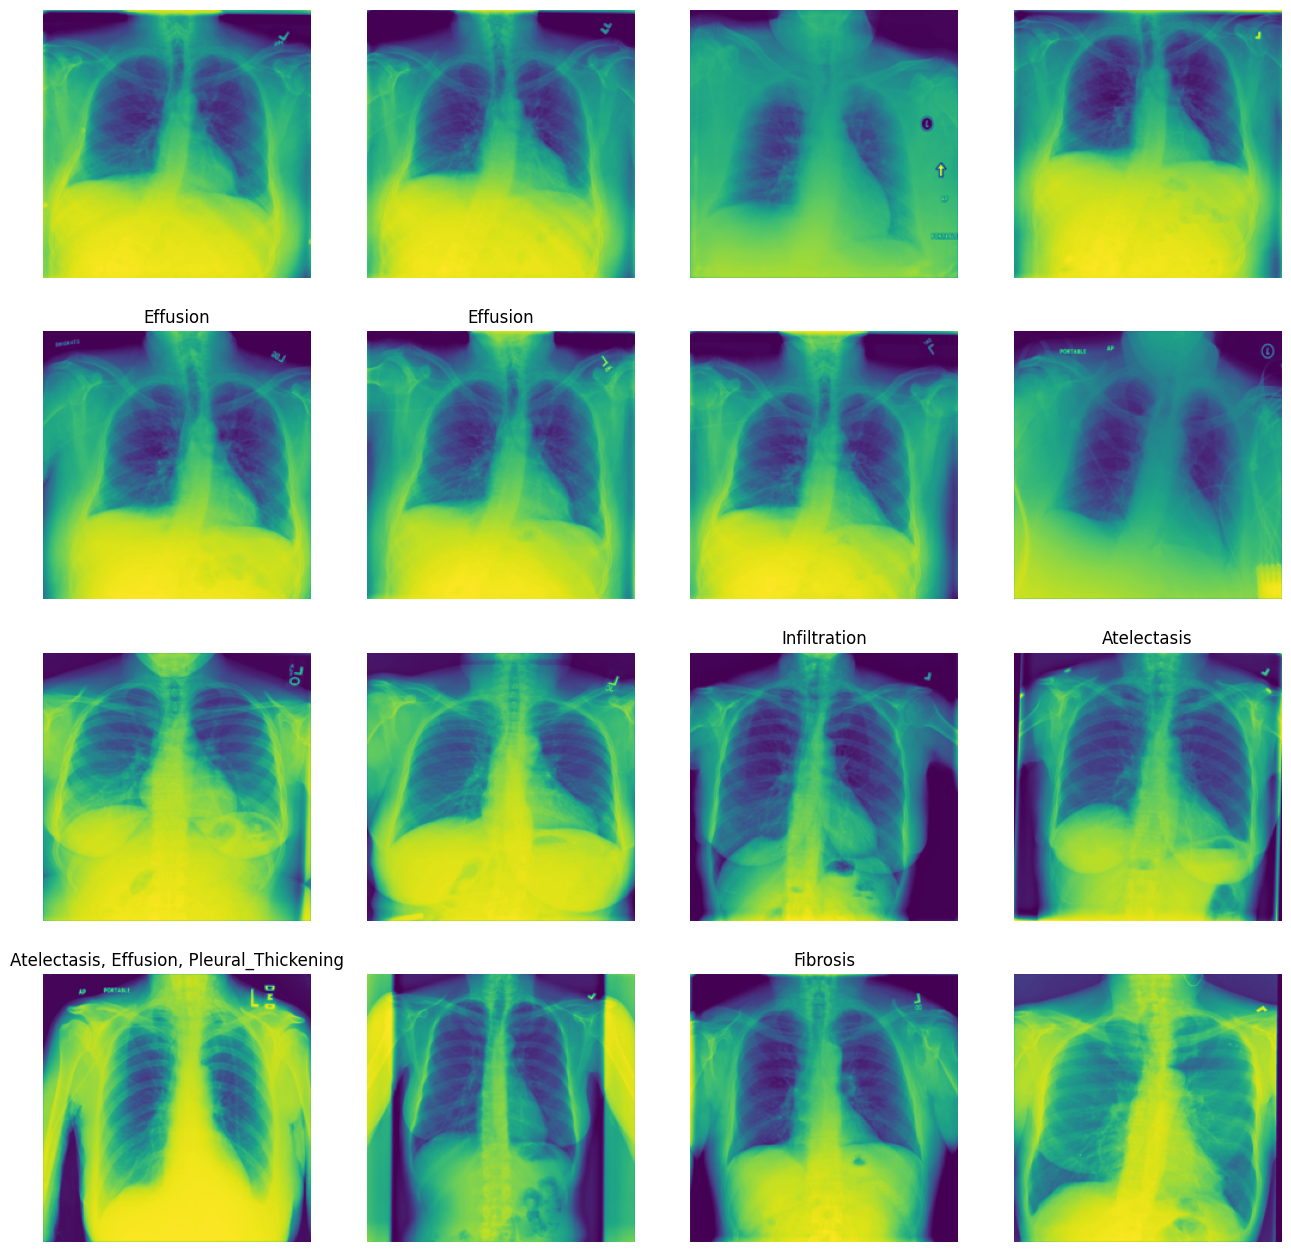

In [78]:
images, labels_encoded = next(test_generator)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for image, label_encoded, ax in zip(images, labels_encoded, axes.flatten()):
    
    # Hiển thị hình ảnh ở kênh đầu tiên (giả sử là grayscale)
    ax.imshow(image[:, :, 0])
    
    predicted_classes = [
        class_name for class_name, class_score in zip(CFG.CLASS_NAMES, label_encoded) 
        if class_score > 0.5
    ]
    
    ax.set_title(', '.join(predicted_classes))
    ax.axis('off')

plt.show()

# CoAtNet build model

In [32]:
def build_model():
    base_model = coatnet.coatnet0(input_shape=(224, 224, 3), include_top=False)

    flatten = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    drop_out = tf.keras.layers.Dropout(0.5)(flatten)
    dense = tf.keras.layers.Dense(2048, activation="relu")(drop_out)
    
    # Use sigmoid activation for multi-label classification
    prediction = tf.keras.layers.Dense(len(CFG.CLASS_NAMES), activation="sigmoid", name="prediction")(dense)
    
    model = tf.keras.Model(base_model.input, prediction)

    # Use binary crossentropy for multi-label classification
    loss = tf.keras.losses.binary_crossentropy
    
    # Adamax optimizer for consistency with DenseNet
    optimizer = tf.keras.optimizers.Adamax(learning_rate=1e-3)
    
    # Metrics suitable for multi-label classification
    metrics = ['binary_accuracy', 'AUC']
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model


In [33]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices (GPU): {}'.format(strategy.num_replicas_in_sync))

Number of devices (GPU): 2


In [34]:
!rm /kaggle/working/CoAtNet_epoch_10.keras

rm: cannot remove '/kaggle/working/CoAtNet_epoch_10.keras': No such file or directory


In [35]:
custom_objects = {
    "MBConv": MBConv,
    "ConvTransformer": ConvTransformer,
    "MultiHeadSelfAttention": MultiHeadSelfAttention
}
def load_or_train_model(start_epoch = CFG.START_EPOCH):
    model_path = f'CoAtNet_epoch_{start_epoch}.keras'
    if os.path.exists(model_path):
        print(f'Loading model from {model_path}')
        multi_gpu_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    else:
        print(f'Model not found. Training from scratch.')
        multi_gpu_model = build_model()  # Huấn luyện từ đầu
    return multi_gpu_model

In [36]:
with strategy.scope():
    multi_gpu_model = load_or_train_model()
multi_gpu_model.summary()

Model not found. Training from scratch.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage0_conv1 (Conv2D)           │ (None, 112, 112, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage0_norm1                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage0_act1 (Activation)        │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage0_conv2 (Conv2D)           │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage0_norm2                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage0_act2 (Activation)        │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_pre_norm1                │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_mbconv1 (MBConv)         │ (None, 56, 56, 96)     │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_pre_norm2                │ (None, 56, 56, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_mbconv2 (MBConv)         │ (None, 56, 56, 96)     │        89,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_pre_norm1                │ (None, 56, 56, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_mbconv1 (MBConv)         │ (None, 28, 28, 192)    │       136,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_pre_norm2                │ (None, 28, 28, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_mbconv2 (MBConv)         │ (None, 28, 28, 192)    │       345,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_pre_norm3                │ (None, 28, 28, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_mbconv3 (MBConv)         │ (None, 28, 28, 192)    │       345,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage3_pre_norm1                │ (None, 28, 28, 192)    │           384 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage3_transformer1             │ (None, 14, 14, 384)    │       622,920 │
│ (ConvTransformer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage3_pre_norm2                │ (None, 14, 14, 384)    │           768 │
│ (LayerNormalization)            │                        │             

 Total params: 9,973,830 (38.05 MB)

 Trainable params: 9,960,518 (38.00 MB)

 Non-trainable params: 13,312 (52.00 KB)

# Training

In [38]:
# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks
checkpoint_val_accuracy = ModelCheckpoint(CFG.CHECKPOINT_PATH_TRAIN_ACCURACY, 
                                          verbose=0, 
                                          monitor='val_accuracy', 
                                          save_best_only=True, 
                                          mode='max')

checkpoint_train_accuracy = ModelCheckpoint(CFG.CHECKPOINT_PATH_VAL_ACCURACY, 
                                            verbose=0, 
                                            monitor='val_binary_accuracy', 
                                            save_best_only=True, 
                                            mode='max')

checkpoint_val_loss = ModelCheckpoint(CFG.CHECKPOINT_PATH_VAL_LOSS, 
                                      verbose=0, 
                                      save_best_only=True)

checkpoint_val_AUC = ModelCheckpoint(CFG.CHECKPOINT_PATH_VAL_AUC, 
                                      verbose=0, 
                                      save_best_only=True, 
                                      monitor='val_AUC', 
                                      mode='max')

checkpoint_train_AUC = ModelCheckpoint(CFG.CHECKPOINT_PATH_TRAIN_AUC, 
                                        verbose=0, 
                                        save_best_only=True, 
                                        monitor='val_AUC', 
                                        mode='max')

checkpoint_train_loss = ModelCheckpoint(CFG.CHECKPOINT_PATH_TRAIN_LOSS, 
                                        verbose=0, 
                                        monitor='loss', 
                                        mode='min', 
                                        save_best_only=True)

anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                         factor=0.1, 
                         patience=2, 
                         verbose=True,
                         min_lr=1e-7)

early_stopping = EarlyStopping(monitor='val_loss', 
                               verbose=1,
                               patience=5, 
                               mode='min')

In [39]:
def plot_history(history, epoch_start, epoch_end):
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss from epoch {epoch_start} to {epoch_end}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(1, 2, 2)
    plt.plot(history.history['AUC'], label='Train AUC')
    plt.plot(history.history['val_AUC'], label='Validation AUC')
    plt.title(f'AUC from epoch {epoch_start} to {epoch_end}')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.savefig(f'training_history_{epoch_start}_to_{epoch_end}.png')
    plt.show()

Training from epoch 1 to 10
Epoch 1/10


I0000 00:00:1728098373.013857     114 service.cc:145] XLA service 0x7ddd7c9b39d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728098373.013931     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728098373.013938     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728098373.570027     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1249/1249 ━━━━━━━━━━━━━━━━━━━━ 2567s 2s/step - AUC: 0.7123 - binary_accuracy: 0.9460 - loss: 0.1963 - val_AUC: 0.7423 - val_binary_accuracy: 0.9491 - val_loss: 0.1832 - learning_rate: 0.0010
Epoch 2/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1695s 1s/step - AUC: 0.7343 - binary_accuracy: 0.9488 - loss: 0.1844 - val_AUC: 0.7465 - val_binary_accuracy: 0.9489 - val_loss: 0.1822 - learning_rate: 0.0010
Epoch 3/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1682s 1s/step - AUC: 0.7368 - binary_accuracy: 0.9488 - loss: 0.1840 - val_AUC: 0.7400 - val_binary_accuracy: 0.9483 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 4/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7353 - binary_accuracy: 0.9482 - loss: 0.1857
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1692s 1s/step - AUC: 0.7353 - binary_accuracy: 0.9482 - loss: 0.1857 - val_AUC: 0.7368 - val_binary_accuracy: 0.9496 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 5/10
1249/1249 ━━━━━━━━

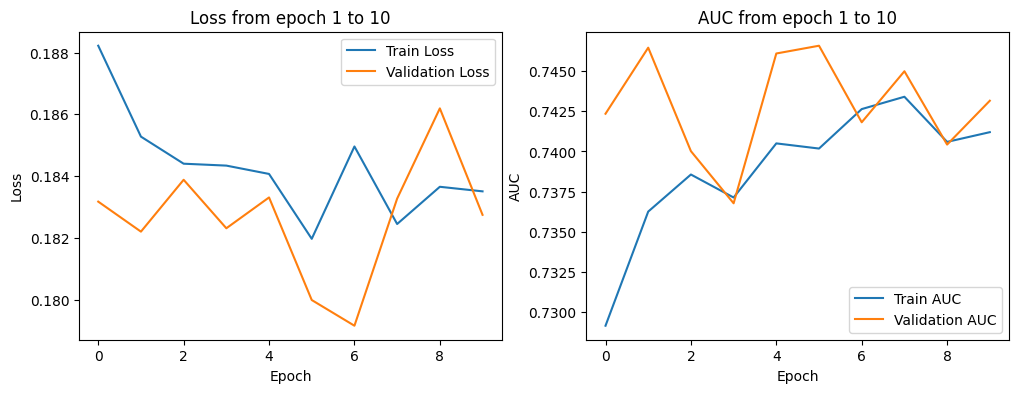

In [40]:
for i in range(CFG.START_EPOCH, CFG.EPOCHS, CFG.EPOCHS_PER_START):
    end_epoch = min(i + CFG.EPOCHS_PER_START, CFG.EPOCHS)
    
    print(f'Training from epoch {i+1} to {end_epoch}')
    
    # Huấn luyện mô hình trong từng phần nhỏ
    history = multi_gpu_model.fit(
        train_generator,
        epochs=end_epoch,
        initial_epoch=i,
        callbacks=[anne,
                   checkpoint_val_loss, checkpoint_val_AUC,
                   checkpoint_train_loss, checkpoint_train_AUC,
                   checkpoint_val_accuracy, checkpoint_train_accuracy],
        validation_data=val_generator,
    )

    
    model_path = f'CoAtNet_epoch_{end_epoch}.keras'
    multi_gpu_model.save(model_path)
    print(f'Model saved after epoch {end_epoch} at {model_path}')
    plot_history(history, i+1, end_epoch)


In [58]:
# multi_gpu_model.save('CoAtNet_10_epoch.keras')
multi_gpu_model.save("/kaggle/working/CoAtNet_10_epoch.h5")
multi_gpu_model.save_weights("/kaggle/working/CoAtNet_10_epoch.weights.h5")


In [ ]:
# # multi_gpu_model.load_weights("CoAtNet_10_epoch.h5")
# loss = tf.keras.losses.binary_crossentropy
# metric = ['AUC']
# model.compile(loss = loss, metrics = metric)
# model.evaluate(te_data)

In [54]:
import tensorflow as tf
import numpy as np

class MBConv(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides = 1, expand_ratio = 1, se_ratio = 4, residual = True, momentum = 0.9, epsilon = 0.01, convolution = tf.keras.layers.Conv2D, activation = tf.nn.swish, kernel_initializer = "he_normal", **kwargs):
        super(MBConv, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.expand_ratio = expand_ratio
        self.se_ratio = se_ratio
        self.residual = residual
        self.momentum = momentum
        self.epsilon = epsilon
        self.convolution = convolution
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        
    def build(self, input_shape):
        input_shape = list(input_shape)
        self.layers = []
        self.post = []
        if self.expand_ratio != 1:
            conv = self.convolution(input_shape[-1] * self.expand_ratio, 1, use_bias=False, kernel_initializer=self.kernel_initializer)
            norm = tf.keras.layers.BatchNormalization(momentum=self.momentum, epsilon=self.epsilon)
            act = tf.keras.layers.Activation(self.activation)
            input_shape = input_shape[:-1] + [input_shape[-1] * self.expand_ratio]
            self.layers += [conv, norm, act]

        # Depthwise Convolution
        conv = self.convolution(input_shape[-1], self.kernel_size, strides=self.strides, groups=input_shape[-1], padding="same", use_bias=False, kernel_initializer=self.kernel_initializer)
        norm = tf.keras.layers.BatchNormalization(momentum=self.momentum, epsilon=self.epsilon)
        act = tf.keras.layers.Activation(self.activation)
        self.layers += [conv, norm, act]

        # Squeeze and Excitation layer, if desired
        axis = list(range(1, len(input_shape) - 1))
        gap = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=axis, keepdims=True))
        squeeze = self.convolution(max(1, int(input_shape[-1] / self.se_ratio)), 1, use_bias=True, kernel_initializer=self.kernel_initializer)
        act = tf.keras.layers.Activation(self.activation)
        excitation = self.convolution(input_shape[-1], 1, use_bias=True, kernel_initializer=self.kernel_initializer)
        se = lambda x: x * tf.nn.sigmoid(excitation(act(squeeze(gap(x)))))
        self.layers += [se]

        # Output Phase
        conv = self.convolution(self.filters, 1, use_bias=False, kernel_initializer=self.kernel_initializer)
        norm = tf.keras.layers.BatchNormalization(momentum=self.momentum, epsilon=self.epsilon)
        self.layers += [conv, norm]

        # Residual
        if self.residual:
            if 1 < self.strides:
                pool = tf.keras.layers.MaxPool2D(pool_size=self.strides + 1, strides=self.strides, padding="same")
                self.post.append(pool)
            if input_shape[-1] != self.filters:
                resample = self.convolution(self.filters, 1, use_bias=False, kernel_initializer=self.kernel_initializer)
                self.post.append(resample)

        
    def call(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
            
        if self.residual:
            for layer in self.post:
                x = layer(x)
            out = out + x
        return out
        
    def get_config(self):
        config = super(MBConv, self).get_config()
        config["filters"] = self.filters
        config["kernel_size"] = self.kernel_size
        config["expand_ratio"] = self.expand_ratio
        config["se_ratio"] = self.se_ratio
        config["residual"] = self.residual
        config["momentum"] = self.momentum
        config["epsilon"] = self.epsilon
        return config

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, emb_dim = 768, n_head = 12, out_dim = None, relative_window_size = None, dropout_rate = 0., kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01), **kwargs):
        #ScaledDotProductAttention
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        self.n_head = n_head
        if emb_dim % n_head != 0:
            raise ValueError("Shoud be embedding dimension % number of heads = 0.")
        if out_dim is None:
            out_dim = self.emb_dim
        self.out_dim = out_dim
        if relative_window_size is not None and np.ndim(relative_window_size) == 0:
            relative_window_size = [relative_window_size, relative_window_size]
        self.relative_window_size = relative_window_size
        self.projection_dim = emb_dim // n_head
        self.dropout_rate = dropout_rate
        self.query = tf.keras.layers.Dense(emb_dim, kernel_initializer = kernel_initializer)
        self.key = tf.keras.layers.Dense(emb_dim, kernel_initializer = kernel_initializer)
        self.value = tf.keras.layers.Dense(emb_dim, kernel_initializer = kernel_initializer)
        self.combine = tf.keras.layers.Dense(out_dim, kernel_initializer = kernel_initializer)
        
    def build(self, input_shape):
        if self.relative_window_size is not None:
            self.relative_position_bias_table = self.add_weight(
                name="relative_position_bias_table",
                shape=[((2 * self.relative_window_size[0]) - 1) * ((2 * self.relative_window_size[1]) - 1), self.n_head],
                trainable=True
            )

            coords_h = np.arange(self.relative_window_size[0])
            coords_w = np.arange(self.relative_window_size[1])
            coords = np.stack(np.meshgrid(coords_h, coords_w, indexing = "ij")) #2, Wh, Ww
            coords = np.reshape(coords, [2, -1])
            
            with tf.init_scope():
                relative_coords = np.expand_dims(coords, axis = -1) - np.expand_dims(coords, axis = -2) #2, Wh * Ww, Wh * Ww
                relative_coords = np.transpose(relative_coords, [1, 2, 0]) #Wh * Ww, Wh * Ww, 2
                relative_coords[:, :, 0] += self.relative_window_size[0] - 1 #shift to start from 0
                relative_coords[:, :, 1] += self.relative_window_size[1] - 1
                relative_coords[:, :, 0] *= 2 * self.relative_window_size[1] - 1
                relative_position_index = np.sum(relative_coords, -1)
                self.relative_position_index = tf.Variable(tf.convert_to_tensor(relative_position_index), trainable = False, name= "relative_position_index")
        
    def attention(self, query, key, value, relative_position_bias = None):
        score = tf.matmul(query, key, transpose_b = True)
        n_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(n_key)
        if relative_position_bias is not None:
            scaled_score = scaled_score + relative_position_bias
        weight = tf.nn.softmax(scaled_score, axis = -1)
        if 0 < self.dropout_rate:
            weight = tf.nn.dropout(weight, self.dropout_rate)
        out = tf.matmul(weight, value)
        return out
    
    def separate_head(self, x):
        out = tf.keras.layers.Reshape([-1, self.n_head, self.projection_dim])(x)
        out = tf.keras.layers.Permute([2, 1, 3])(out)
        return out
    
    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)
        
        query = self.separate_head(query)
        key = self.separate_head(key)
        value = self.separate_head(value)
        
        relative_position_bias = None
        if self.relative_window_size is not None:
            relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(self.relative_position_index, [-1]))
            relative_position_bias = tf.reshape(relative_position_bias, [self.relative_window_size[0] * self.relative_window_size[1], self.relative_window_size[0] * self.relative_window_size[1], -1]) #Wh * Ww,Wh * Ww, nH
            relative_position_bias = tf.transpose(relative_position_bias, [2, 0, 1]) #nH, Wh * Ww, Wh * Ww
            relative_position_bias = tf.expand_dims(relative_position_bias, axis = 0)
        attention = self.attention(query, key, value, relative_position_bias)
        attention = tf.keras.layers.Permute([2, 1, 3])(attention)
        attention = tf.keras.layers.Reshape([-1, self.emb_dim])(attention)
        
        out = self.combine(attention)
        return out
        
    def get_config(self):
        config = super(MultiHeadSelfAttention, self).get_config()
        config["emb_dim"] = self.emb_dim
        config["n_head"] = self.n_head
        config["out_dim"] = self.out_dim
        config["relative_window_size"] = self.relative_window_size
        config["projection_dim"] = self.projection_dim
        config["dropout_rate"] = self.dropout_rate
        return config
        
class ConvTransformer(tf.keras.layers.Layer):
    def __init__(self, emb_dim = 768, n_head = 12, strides = 1, out_dim = None, epsilon = 1e-5, dropout_rate = 0., activation = tf.keras.activations.gelu, kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01), **kwargs):
        super(ConvTransformer, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        self.n_head = n_head
        self.strides = strides
        self.out_dim = out_dim if out_dim is not None else emb_dim
        self.epsilon = epsilon
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        
    def build(self, input_shape):
        self.attention = []
        self.residual = []
        
        #Attention
        shape = input_shape[1:3]
        if 1 < self.strides:
            shape = np.divide(np.add(shape, (self.strides - 1)), self.strides).astype(int)
            pool = tf.keras.layers.MaxPool2D(pool_size = self.strides + 1, strides = self.strides, padding = "same")
            self.attention.append(pool)
            self.residual.append(pool)
        if input_shape[-1] != self.out_dim:
            resample = tf.keras.layers.Conv2D(self.out_dim, 1, padding = "same", use_bias = False, kernel_initializer = "he_normal")
            self.residual.append(resample)
        pre_reshape = tf.keras.layers.Reshape([-1, input_shape[-1]])
        mhsa = MultiHeadSelfAttention(emb_dim = self.emb_dim, n_head = self.n_head, out_dim = self.out_dim, relative_window_size = shape, dropout_rate = self.dropout_rate)
        post_reshape = tf.keras.layers.Reshape([*shape, self.out_dim])
        self.attention += [pre_reshape, mhsa, post_reshape]
        
        self.ffn = []
        #Feed Forward Network
        norm = tf.keras.layers.LayerNormalization(epsilon = self.epsilon)
        dense1 = tf.keras.layers.Dense(self.out_dim, kernel_initializer = self.kernel_initializer)
        act = tf.keras.layers.Activation(self.activation)
        dense2 = tf.keras.layers.Dense(self.out_dim, kernel_initializer = self.kernel_initializer)
        self.ffn = [norm, dense1, act, dense2]
    
    def call(self, inputs):
        out = inputs
        for layer in self.attention:
            out = layer(out)
        for layer in self.residual:
            inputs = layer(inputs)
        out = out + inputs
        
        for layer in self.ffn:
            out = layer(out)
        return out
        
    def get_config(self):
        config = super(ConvTransformer, self).get_config()
        config["emb_dim"] = self.emb_dim
        config["n_head"] = self.n_head
        config["strides"] = self.strides
        config["out_dim"] = self.out_dim
        config["epsilon"] = self.epsilon
        config["dropout_rate"] = self.dropout_rate
        return config
    
def coatnet(x, n_class = 1000, include_top = True, n_depth = [2, 2, 6, 14, 2], n_feature = [64, 96, 192, 384, 768], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu, name = ""):
    #block : S > Stem, C > MBConv, T > Transformer
    if 0 < len(name):
        name += "_"
    if isinstance(stage_stride_size, int):
        stage_stride_size = [stage_stride_size] * len(block)
        
    out = x
    for i, (_n_depth, _n_feature, _block, _stage_stride_size) in enumerate(zip(n_depth, n_feature, block, stage_stride_size)):
        for j in range(_n_depth):
            stride_size = 1 if j != 0 else _stage_stride_size
            residual = out
            if _block.upper() == "C":# i == 0:
                out = tf.keras.layers.Conv2D(_n_feature, 1 if i != 0 else 3, strides = stride_size, padding = "same", use_bias = False, kernel_initializer = "he_normal", name = "{0}stage{1}_conv{2}".format(name, i, j + 1))(out)
                out = tf.keras.layers.BatchNormalization(momentum = 0.9, epsilon = 1e-5, name = "{0}stage{1}_norm{2}".format(name, i, j + 1))(out)
                out = tf.keras.layers.Activation(activation, name = "{0}stage{1}_act{2}".format(name, i, j + 1))(out)
            elif _block.upper() == "M":
                out = tf.keras.layers.BatchNormalization(momentum = 0.9, epsilon = 1e-5, name = "{0}stage{1}_pre_norm{2}".format(name, i, j + 1))(out)
                out = MBConv(_n_feature, 3, strides = stride_size, expand_ratio = expand_ratio, se_ratio = se_ratio, residual = True, momentum = 0.9, epsilon = 1e-5, activation = activation, name = "{0}stage{1}_mbconv{2}".format(name, i, j + 1))(out)
            elif _block.upper() == "T":
                out = tf.keras.layers.LayerNormalization(epsilon = 1e-5, name = "{0}stage{1}_pre_norm{2}".format(name, i, j + 1))(out)
                out = ConvTransformer(32 * 8, 8, strides = stride_size, out_dim = _n_feature, epsilon = 1e-5, activation = activation, name = "{0}stage{1}_transformer{2}".format(name, i, j + 1))(out)

    if include_top:
        out = tf.keras.layers.GlobalAveragePooling2D(name = "{0}gap".format(name))(out)
        if 0 < dropout_rate:
            out = tf.keras.layers.Dropout(dropout_rate, name = "{0}dropout".format(name))(out)
        out = tf.keras.layers.Dense(n_class, kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01), name = "{0}logits".format(name))(out)
    return out

def coatnet0(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 3, 5, 2], n_feature = [64, 96, 192, 384, 768], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model

def coatnet1(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 6, 14, 2], n_feature = [64, 96, 192, 384, 768], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model

def coatnet2(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 6, 14, 2], n_feature = [128, 128, 256, 512, 1024], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model

def coatnet3(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 6, 14, 2], n_feature = [192, 192, 384, 768, 1536], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model

def coatnet4(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 12, 28, 2], n_feature = [192, 192, 384, 768, 1536], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model

def coatnet5(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 12, 28, 2], n_feature = [192, 256, 512, 1280, 2048], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model

def coatnet6(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 4, 8, 42, 2], n_feature = [192, 192, 384, 768, 1536, 2048], block = ["C", "M", "M", "M", "T", "T"], stage_stride_size = [2, 2, 2, 2, 1, 2], expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model

def coatnet7(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 4, 8, 42, 2], n_feature = [192, 256, 512, 1024, 2048, 3072], block = ["C", "M", "M", "M", "T", "T"], stage_stride_size = [2, 2, 2, 2, 1, 2], expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model


# Model evaluating

In [52]:
# !rm -rf /kaggle/working/coatnet

In [62]:
custom_objects = {
    "MBConv": MBConv,
    "ConvTransformer": ConvTransformer,
    "MultiHeadSelfAttention": MultiHeadSelfAttention
}
# load_coatnet_model = tf.keras.models.load_model("/kaggle/working/CoAtNet_10_epoch.h5", custom_objects=custom_objects, by_name=True)

load_coatnet_model = tf.keras.models.load_model("/kaggle/working/model/coatnet_val_AUC.keras", custom_objects=custom_objects, compile=False)
# load_coatnet_model.load_weights('/path/to/weights.h5', by_name=True)

RuntimeError: Exception encountered when calling ConvTransformer.call().

[1mCould not automatically infer the output shape / dtype of 'stage3_transformer1' (of type ConvTransformer). Either the `ConvTransformer.call()` method is incorrect, or you need to implement the `ConvTransformer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Exception encountered when calling MultiHeadSelfAttention.call().

[1mDimensions must be equal, but are 3136 and 196 for '{{node multi_head_self_attention_42_1/add}} = AddV2[T=DT_FLOAT](multi_head_self_attention_42_1/truediv, multi_head_self_attention_42_1/ExpandDims)' with input shapes: [?,8,3136,3136], [1,8,196,196].[0m

Arguments received by MultiHeadSelfAttention.call():
  • inputs=tf.Tensor(shape=(None, 3136, 192), dtype=float32)[0m

Arguments received by ConvTransformer.call():
  • args=('<KerasTensor shape=(None, 112, 112, 192), dtype=float32, sparse=False, name=keras_tensor_417>',)
  • kwargs=<class 'inspect._empty'>

In [63]:
# Smaller batch size to fit within memory constraints
batch_size = 512

# Adjust the test generator with the new batch size
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE,
    shuffle=False  # Ensure data order is consistent
)

Found 23573 validated image filenames.


In [65]:
def ROC_AUC (model):
    y_preds = []
    y_trues = []

    # Iterate over the test generator and collect predictions
    for _ in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch, verbose=0)
        y_preds.append(y_pred_batch)
        y_trues.append(y_batch)

    # Concatenate all batches together
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)

    # Extract class labels from the dataframe columns
    class_labels = test_df[CFG.CLASS_NAMES].columns

    # Compute the ROC AUC score for each class
    roc_auc_scores = {}
    for i, label in enumerate(class_labels):
        auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
        roc_auc_scores[label] = auc

    # Print the ROC AUC scores
    for label, auc in roc_auc_scores.items():
        print(f"ROC AUC Score for {label}: {auc:.4f}")

    # Calculate and print the average ROC AUC score
    average_roc_auc = np.mean(list(roc_auc_scores.values()))
    print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

In [66]:
ROC_AUC(multi_gpu_model)

ROC AUC Score for Atelectasis: 0.4899
ROC AUC Score for Cardiomegaly: 0.5217
ROC AUC Score for Effusion: 0.4976
ROC AUC Score for Infiltration: 0.5017
ROC AUC Score for Mass: 0.4954
ROC AUC Score for Nodule: 0.4972
ROC AUC Score for Pneumonia: 0.5005
ROC AUC Score for Pneumothorax: 0.5257
ROC AUC Score for Consolidation: 0.4954
ROC AUC Score for Edema: 0.4655
ROC AUC Score for Emphysema: 0.4939
ROC AUC Score for Fibrosis: 0.4813
ROC AUC Score for Pleural_Thickening: 0.5243
ROC AUC Score for Hernia: 0.4644
Average ROC AUC Score: 0.4968


In [67]:
y_preds = []
y_trues = []

In [69]:
# Iterate over the test generator and collect predictions
for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred_batch = multi_gpu_model.predict(x_batch, verbose =0)
    y_preds.append(y_pred_batch)
    y_trues.append(y_batch)

In [70]:
# Convert lists to numpy arrays for slicing
y_preds = np.vstack(y_preds)  # Stack predictions vertically
y_trues = np.vstack(y_trues)  # Stack ground truth labels vertically

In [71]:
# Compute the ROC AUC score for each class
roc_auc_scores = {}
for i, label in enumerate(CFG.CLASS_NAMES):
    auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
    roc_auc_scores[label] = auc

# Print the ROC AUC scores
for label, auc in roc_auc_scores.items():
    print(f"ROC AUC Score for {label}: {auc:.4f}")

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

ROC AUC Score for Atelectasis: 0.4899
ROC AUC Score for Cardiomegaly: 0.5217
ROC AUC Score for Effusion: 0.4976
ROC AUC Score for Infiltration: 0.5017
ROC AUC Score for Mass: 0.4954
ROC AUC Score for Nodule: 0.4972
ROC AUC Score for Pneumonia: 0.5005
ROC AUC Score for Pneumothorax: 0.5257
ROC AUC Score for Consolidation: 0.4954
ROC AUC Score for Edema: 0.4655
ROC AUC Score for Emphysema: 0.4939
ROC AUC Score for Fibrosis: 0.4813
ROC AUC Score for Pleural_Thickening: 0.5243
ROC AUC Score for Hernia: 0.4644
Average ROC AUC Score: 0.4968


Micro-Average ROC AUC Score: 0.7499


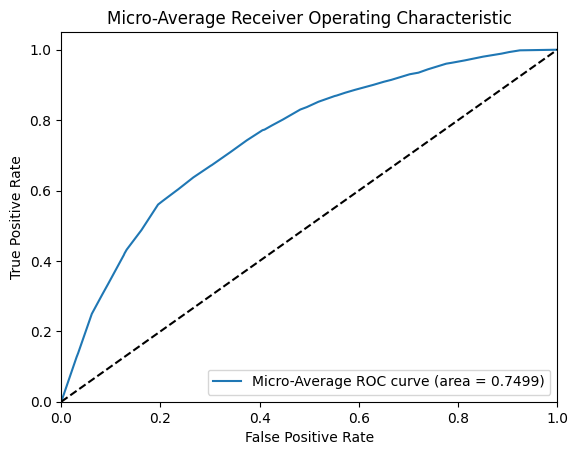

In [72]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute the ROC AUC score (micro-average)
roc_auc_micro = roc_auc_score(y_trues, y_preds, average='micro')
print(f"Micro-Average ROC AUC Score: {roc_auc_micro:.4f}")

# Compute the ROC curve (micro-average)
fpr, tpr, _ = roc_curve(y_trues.ravel(), y_preds.ravel())

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Micro-Average ROC curve (area = {roc_auc_micro:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Save the figure
plt.savefig('Micro-Average-ROC.png', bbox_inches='tight')

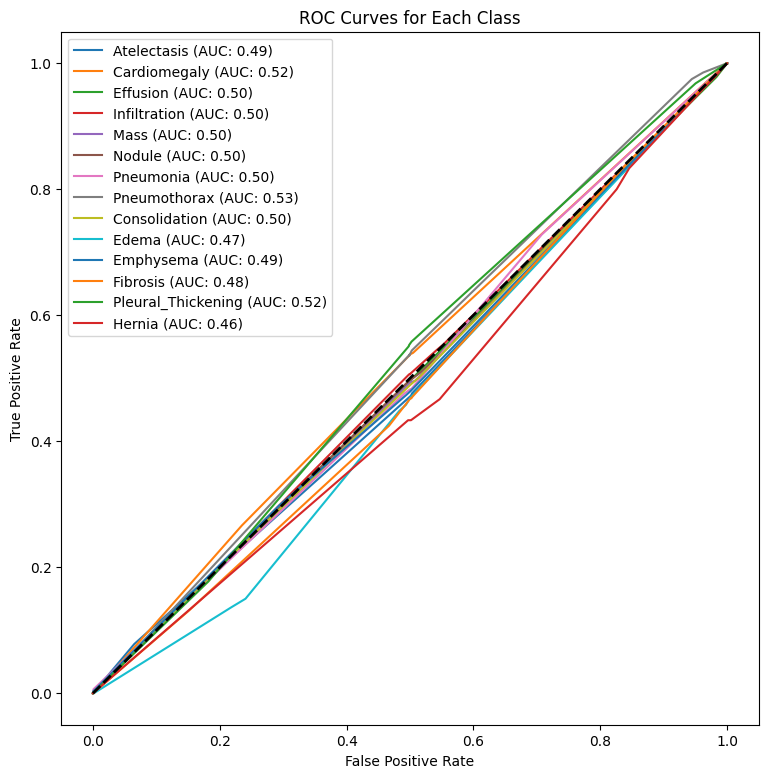

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_trues and y_preds are already defined
# class_labels should be a list of class names

# Plot ROC curves for each class
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(CFG.CLASS_NAMES):
    fpr, tpr, thresholds = roc_curve(y_trues[:, idx], y_preds[:, idx])
    auc_score = auc(fpr, tpr)
    c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc_score:.2f})')

# Plotting the diagonal line
c_ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curves for Each Class')
c_ax.legend(loc='best')

# Save the figure
fig.savefig('ROC Curves.png')
plt.show()

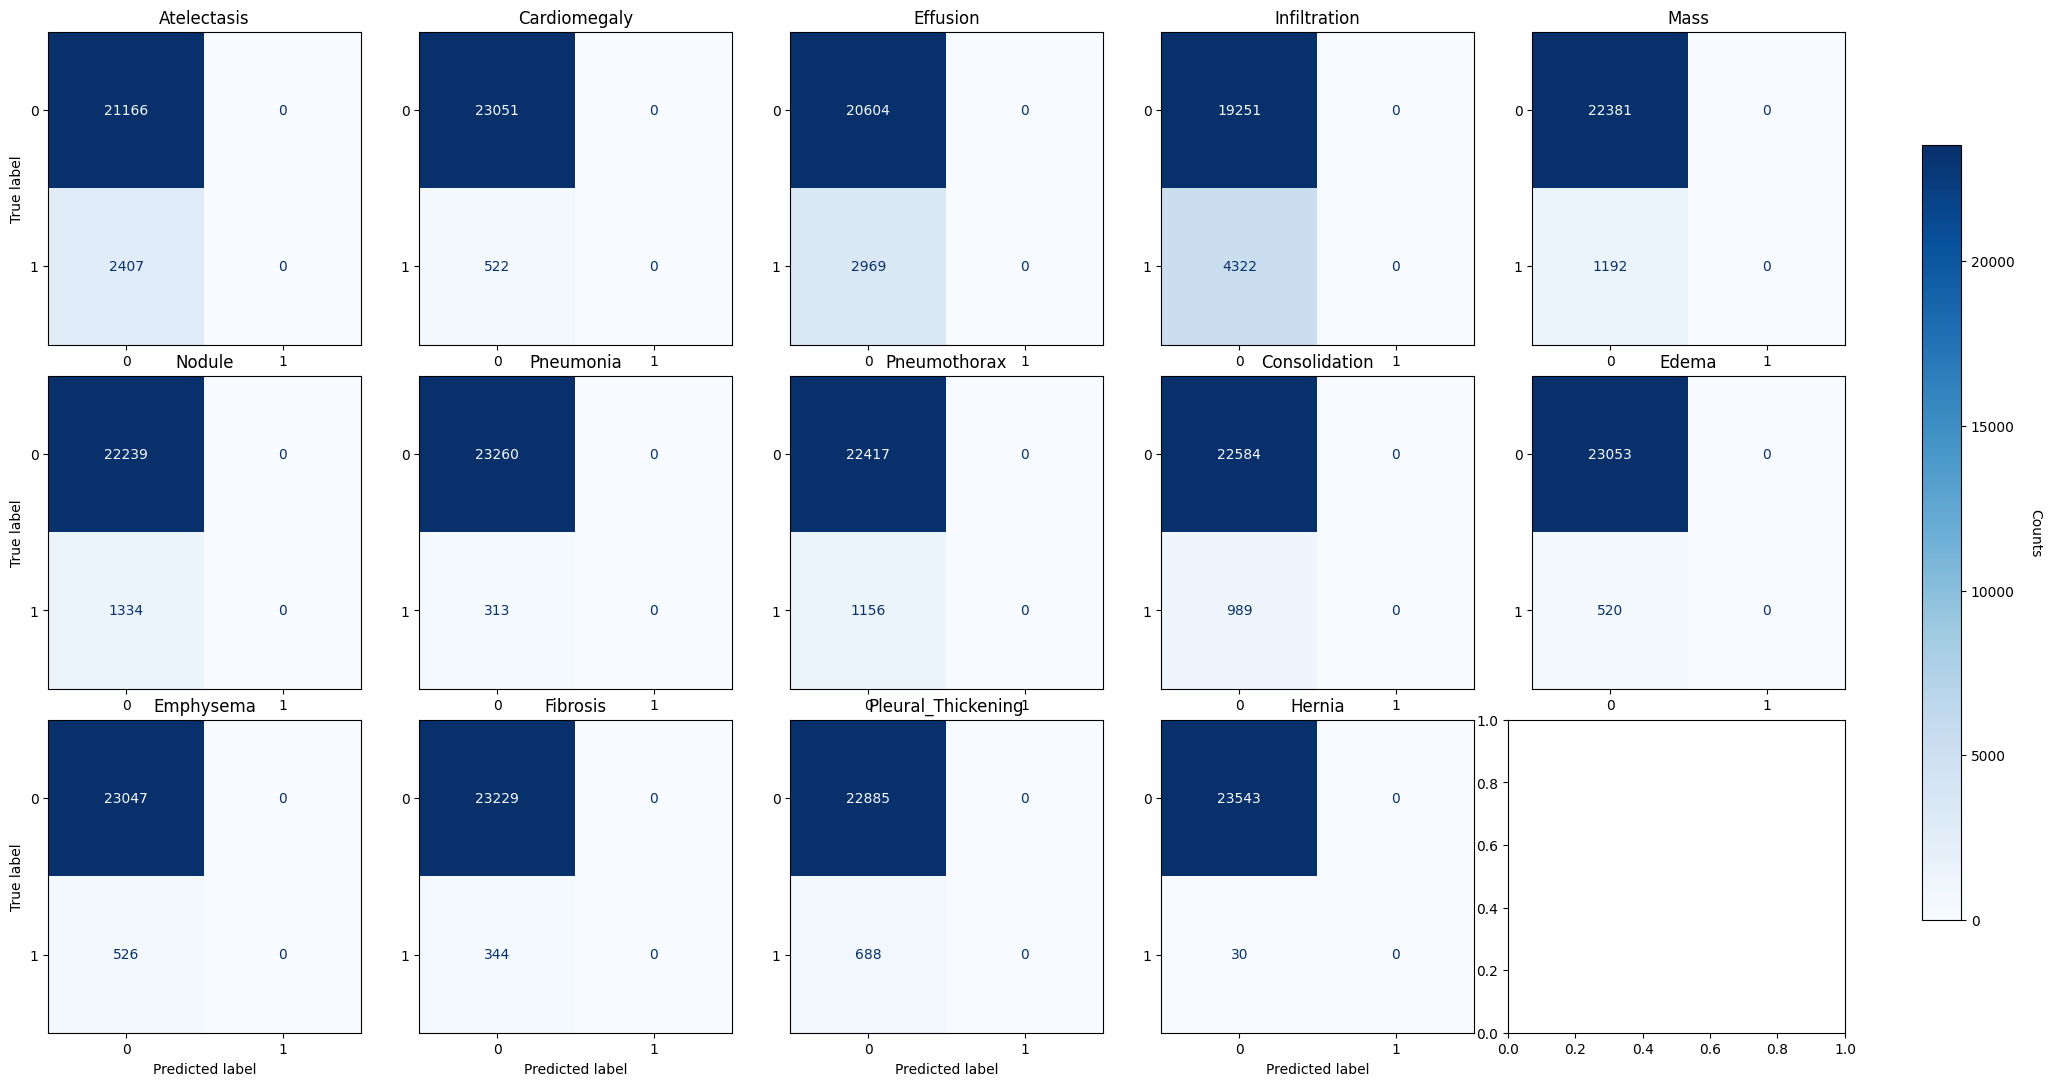

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Assume y_preds and y_trues are already defined as above
y_pred = (y_preds > 0.5).astype(int)
y_true = y_trues

# Calculate the confusion matrix for each label
cm = multilabel_confusion_matrix(y_true, y_pred)

# Set the figure size and create subplots
f, axes = plt.subplots(3, 5, figsize=(25, 13))
axes = axes.ravel()

# Loop through each class label
for i in range(len(CFG.CLASS_NAMES)):
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]),
                                  display_labels=[0, 1])  # Assuming binary labels (0, 1)
    # Set the color map to 'Blues' and float the colorbar
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')  # Change to '.2f' for two decimal places
    disp.ax_.set_title(CFG.CLASS_NAMES[i])

    # Adjust axis labels
    if i < 10:
        disp.ax_.set_xlabel('')
    if i % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()  # Remove the individual colorbar

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.10, hspace=0.1)

# Add a single, shared colorbar
cbar = f.colorbar(disp.im_, ax=axes, location='right', fraction=0.02, pad=0.04)
cbar.ax.set_ylabel('Counts', rotation=270, labelpad=20)

# Save the plot as a PNG file
plt.savefig('confusion_matrix.png', bbox_inches='tight')

<Figure size 3000x2800 with 0 Axes>

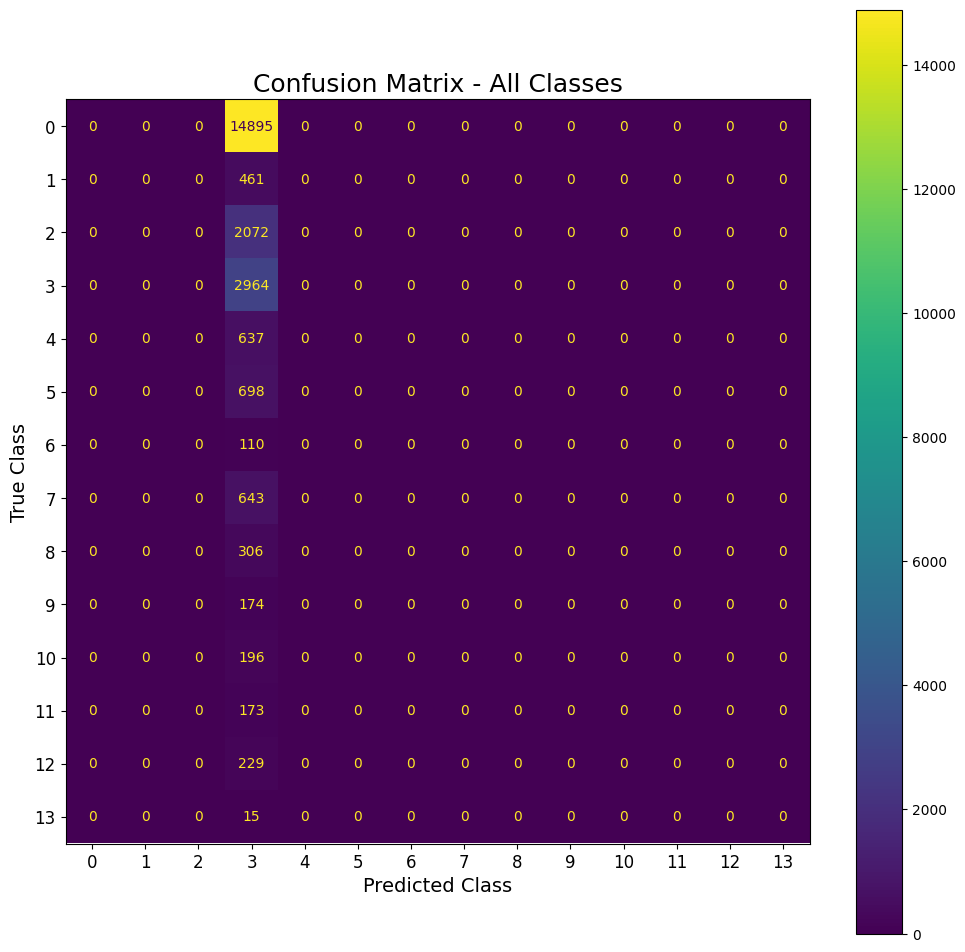

In [75]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true and y_preds should be one-hot encoded or label-encoded class-wise predictions
# Assuming y_preds and y_trues are defined

# Convert the one-hot encoded labels to single label for each sample
y_true_single = np.argmax(y_trues, axis=1)
y_pred_single = np.argmax(y_preds, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_single, y_pred_single)

# Increase figure size for larger cells
plt.figure(figsize=(30, 28))  # Increase the figure size

# Create the ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
fig, ax = plt.subplots(figsize=(12,12))
# Plot the confusion matrix with larger text
disp.plot(cmap='viridis', values_format='d', ax=ax, )  # values_format='d' for integer format

# Increase font size for labels and title
plt.title('Confusion Matrix - All Classes', fontsize=18)  # Larger title
plt.xlabel('Predicted Class', fontsize=14)  # Larger x-axis label
plt.ylabel('True Class', fontsize=14)  # Larger y-axis label
plt.xticks(fontsize=12)  # Larger x-axis ticks
plt.yticks(fontsize=12)  # Larger y-axis ticks

# Save and display the plot
plt.savefig('unified_confusion_matrix_large_cells.png', bbox_inches='tight')
plt.show()

In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
y_pred_classes = np.where(y_preds > 0.5, 1, 0)  # Assuming binary classification

In [77]:
# Initialize dictionaries to hold scores per class
precision_scores = {}
recall_scores = {}
f1_scores = {}
accuracy_scores = {}

# Extract class labels from the dataframe columns
class_labels = test_df[CFG.CLASS_NAMES].columns

for i, label in enumerate(class_labels):
    precision = precision_score(y_trues[:, i], y_pred_classes[:, i])
    recall = recall_score(y_trues[:, i], y_pred_classes[:, i])
    f1 = f1_score(y_trues[:, i], y_pred_classes[:, i])
    accuracy = accuracy_score(y_trues[:, i], y_pred_classes[:, i])
    
    # Store the scores
    precision_scores[label] = precision
    recall_scores[label] = recall
    f1_scores[label] = f1
    accuracy_scores[label] = accuracy

# Print the metrics for each class
for label in class_labels:
    print(f"{label} - Precision: {precision_scores[label]:.4f}, Recall: {recall_scores[label]:.4f}, F1 Score: {f1_scores[label]:.4f}, Accuracy: {accuracy_scores[label]:.4f}")

Atelectasis - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.8979
Cardiomegaly - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9779
Effusion - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.8741
Infiltration - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.8167
Mass - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9494
Nodule - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9434
Pneumonia - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9867
Pneumothorax - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9510
Consolidation - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9580
Edema - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9779
Emphysema - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9777
Fibrosis - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9854
Pleural_Thicken

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming precision_scores, recall_scores, f1_scores, and accuracy_scores are already calculated

# Extract class labels from the dictionary keys
class_labels = list(precision_scores.keys())

# Combine all metrics into a single matrix
metrics_matrix = np.array([
    list(precision_scores.values()),
    list(recall_scores.values()),
    list(f1_scores.values()),
    list(accuracy_scores.values())
])

# Define the metric names
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Plotting the metrics in a matrix-style grid
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(metrics_matrix, cmap='Blues')

# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(metric_names)))

# Label the axes with class names and metric names
ax.set_xticklabels(class_labels, rotation=45, ha="left")
ax.set_yticklabels(metric_names)

# Loop over data dimensions and create text annotations
for i in range(len(metric_names)):
    for j in range(len(class_labels)):
        ax.text(j, i, f'{metrics_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Set titles and layout
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Metrics per Class')
fig.savefig('Metrics per Class.png')
plt.show()